In [1]:
# Imports
import pymssql
import pandas as pd
import numpy as np
from config import database
from config import username
from config import password
from config import server
from config import asthma_table
from config import aq_table
from config import census_table
from config import county_table
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump
from sklearn.impute import SimpleImputer



In [2]:
conn = pymssql.connect(server, username, password, database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    INNER JOIN {county_table} ON {asthma_table}.COUNTY_ID = {county_table}.COUNTY_ID
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query, conn)
print(len(df))
df.head(10)



247


,ASTHMA_ID,COUNTY_ID,YEAR,NUM_ED_VISITS,AGE_ADJ_ED_VISITS,AQ_ID,AQ_ID,COUNTY_ID,YEAR,LEAD_MEAN,...,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,SO2_METHOD_ID,SO2_METRIC_ID,SO2_UNITS_ID,COUNTY_ID,COUNTY_NAME,STATE_ID
0,220,862,2018,1770,38.0,767,767,862,2018,NaN,...,NaN,NaN,NaN,NaN,3,2,2,862,Sonoma,15
1,49,809,2015,3281,60.7,768,768,809,2015,NaN,...,NaN,NaN,NaN,NaN,3,2,2,809,Stanislaus,15
2,119,65,2017,198,55.1,769,769,65,2017,NaN,...,NaN,NaN,NaN,NaN,3,2,2,65,Calaveras,15
3,236,46,2019,5910,54.2,770,770,46,2019,NaN,...,NaN,NaN,NaN,NaN,3,2,2,46,Contra Costa,15
4,74,603,2016,487,79.4,771,771,603,2016,NaN,...,NaN,NaN,NaN,NaN,3,2,2,603,Lake,15
5,100,1737,2016,5534,29.1,772,772,1737,2016,NaN,...,1.800000,1.60,0.381402,1.70,3,2,2,1737,Santa Clara,15
6,19,3118,2015,52227,53.1,773,773,3118,2015,0.012374,...,21.666667,8.30,1.838851,9.70,3,2,2,3118,Los Angeles,15
7,94,2343,2016,10068,30.9,774,774,2343,2016,NaN,...,1.200000,0.65,0.154843,0.65,3,2,2,2343,San Diego,15
8,147,586,2017,10076,43.2,775,775,586,2017,0.005121,...,2.500000,1.90,0.414118,2.30,3,2,2,586,Riverside,15
9,87,2491,2016,8878,29.2,776,776,2491,2016,NaN,...,3.300000,2.10,0.496436,3.20,3,2,2,2491,Orange,15


In [3]:
# Exploratory
df.drop(['ASTHMA_ID', "NUM_ED_VISITS", "AQ_ID", "STATE_ID"],
        axis=1, inplace=True, errors="ignore") 
params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   COUNTY_ID          247 non-null    int64  
 1   YEAR               247 non-null    int64  
 2   AGE_ADJ_ED_VISITS  247 non-null    float64
 3   COUNTY_ID          247 non-null    int64  
 4   YEAR               247 non-null    int64  
 5   LEAD_MEAN          17 non-null     float64
 6   LEAD_1STMAX        17 non-null     float64
 7   LEAD_99PERC        17 non-null     float64
 8   LEAD_STD           17 non-null     float64
 9   LEAD_2NDMAX        17 non-null     float64
 10  NO2_MEAN           163 non-null    float64
 11  NO2_1STMAX         163 non-null    float64
 12  NO2_99PERC         163 non-null    float64
 13  NO2_STD            163 non-null    float64
 14  NO2_2NDMAX         163 non-null    float64
 15  OZONE_MEAN         240 non-null    float64
 16  OZONE_1STMAX       240 non

In [4]:
### Clean it
# Drop unnecessary columns

params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

# Remove lead and PM10 columns because they have so few measurements
params = ["LEAD", "PM10"]
for param in params:
    df.drop([f"{param}_MEAN", f"{param}_1STMAX",
            f"{param}_99PERC", f"{param}_STD", f"{param}_2NDMAX"],
            axis=1, inplace=True, errors="ignore")

# # Remove any rows that still have nulls
#df.dropna(axis=0, how="any", inplace=True)

df[:]


,COUNTY_ID,YEAR,AGE_ADJ_ED_VISITS,COUNTY_ID,YEAR,NO2_MEAN,NO2_1STMAX,NO2_99PERC,NO2_STD,NO2_2NDMAX,...,PM25_99PERC,PM25_STD,PM25_2NDMAX,SO2_MEAN,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,COUNTY_ID,COUNTY_NAME
0,862,2018,38.0,862,2018,10.831921,65.100,45.000,8.739281,56.400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,862,Sonoma
1,809,2015,60.7,809,2015,18.957880,42.000,38.000,8.758836,38.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,809,Stanislaus
2,65,2017,55.1,65,2017,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,Calaveras
3,46,2019,54.2,46,2019,12.650939,39.325,33.325,7.373577,35.825,...,25.50,3.794034,17.200,NaN,NaN,NaN,NaN,NaN,46,Contra Costa
4,603,2016,79.4,603,2016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,603,Lake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,1775,2017,91.7,1775,2017,17.684831,49.200,43.600,11.458889,49.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1775,Solano
243,1113,2019,60.2,1113,2019,19.701047,47.450,42.100,9.399910,43.750,...,22.20,4.833899,22.225,1.241716,7.5,5.2,1.234593,5.6,1113,Imperial
244,1797,2017,70.7,1797,2017,NaN,NaN,NaN,NaN,NaN,...,19.82,4.240796,31.100,0.131646,1.1,0.5,0.120954,0.5,1797,Inyo
245,152,2018,42.2,152,2018,15.176731,51.900,40.500,8.251028,47.400,...,192.50,32.422845,299.900,NaN,NaN,NaN,NaN,NaN,152,Butte


In [5]:
## Do a correlation matrix to see how it all looks
corrMatrix = df.loc[:, ~df.columns.isin(
    ['YEAR', 'COUNTY_NAME', 'COUNTY_ID'])].corr()
print(corrMatrix)


                   AGE_ADJ_ED_VISITS  NO2_MEAN  NO2_1STMAX  NO2_99PERC  \
AGE_ADJ_ED_VISITS           1.000000 -0.021139   -0.064298   -0.073378   
NO2_MEAN                   -0.021139  1.000000    0.864178    0.909016   
NO2_1STMAX                 -0.064298  0.864178    1.000000    0.959608   
NO2_99PERC                 -0.073378  0.909016    0.959608    1.000000   
NO2_STD                    -0.049937  0.870100    0.883105    0.941416   
NO2_2NDMAX                 -0.072682  0.890556    0.981767    0.984549   
OZONE_MEAN                  0.110579  0.447888    0.294038    0.332421   
OZONE_1STMAX                0.131153  0.629714    0.467283    0.485924   
OZONE_99PERC                0.144271  0.579403    0.391246    0.435271   
OZONE_STD                   0.265843  0.533410    0.382473    0.418485   
OZONE_2NDMAX                0.128170  0.603987    0.436486    0.459172   
PM25_MEAN                   0.351111  0.225897    0.212884    0.232399   
PM25_1STMAX                 0.139768 -

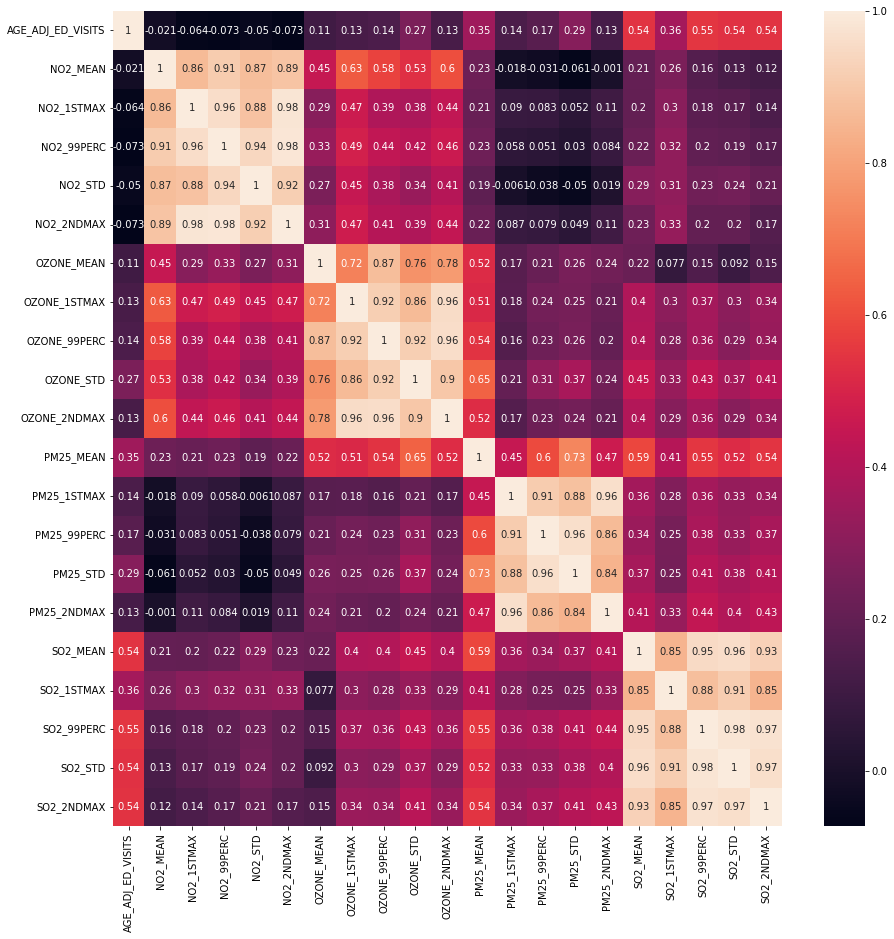

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
sn.heatmap(corrMatrix, annot=True)

plt.show()


This shows some troubling correlations between NO2 and ozone that may indicate multi-colinearity between the two. Additionally, the NO2 correlation to the asthma rate appears very low. Because of that, remove the NO2 variables and continue.

In [7]:
# Remove NO2 columns 
params = ["NO2"]
for param in params:
    df.drop([f"{param}_MEAN", f"{param}_1STMAX",
            f"{param}_99PERC", f"{param}_STD", f"{param}_2NDMAX"],
            axis=1, inplace=True, errors="ignore")

In [8]:
df.isnull().sum()


COUNTY_ID              0
YEAR                   0
AGE_ADJ_ED_VISITS      0
COUNTY_ID              0
YEAR                   0
OZONE_MEAN             7
OZONE_1STMAX           7
OZONE_99PERC           7
OZONE_STD              7
OZONE_2NDMAX           7
PM25_MEAN            141
PM25_1STMAX          141
PM25_99PERC          141
PM25_STD             141
PM25_2NDMAX          141
SO2_MEAN             204
SO2_1STMAX           204
SO2_99PERC           204
SO2_STD              204
SO2_2NDMAX           204
COUNTY_ID              0
COUNTY_NAME            0
dtype: int64

There are a lot of empty rows in the PM25 and SO2 columns. The data set is small already so it would be nice to be able to impute values for them and continue. Create two dataframes to compare: one that drops the empty columns and one that we impute values for missing data.

There are also some duplicate columns due to the merge operation during loading. Let's get rid of them so we can reference those columns directly.

In [9]:
# # Remove any rows that still have nulls
df_dropnulls = df.dropna(axis=0, how="any", inplace=False)
df_dropnulls.drop(['YEAR', "COUNTY_NAME"],
        axis=1, inplace=True, errors="ignore") 
print(df_dropnulls.shape)
df_dropnulls

(42, 19)


D:\Users\Darrell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,COUNTY_ID,AGE_ADJ_ED_VISITS,COUNTY_ID,OZONE_MEAN,OZONE_1STMAX,OZONE_99PERC,OZONE_STD,OZONE_2NDMAX,PM25_MEAN,PM25_1STMAX,PM25_99PERC,PM25_STD,PM25_2NDMAX,SO2_MEAN,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,COUNTY_ID
5,1737,29.1,1737,0.044737,0.088250,0.077750,0.011794,0.082750,8.045263,22.700000,22.700000,3.834162,20.300000,0.537047,1.800000,1.600000,0.381402,1.700000,1737
6,3118,53.1,3118,0.054857,0.112308,0.099923,0.017255,0.105385,10.928321,51.410000,40.335000,6.861900,42.685000,1.849615,21.666667,8.300000,1.838851,9.700000,3118
7,2343,30.9,2343,0.050642,0.085727,0.080727,0.010884,0.082818,8.451769,23.533333,19.866667,3.427879,18.600000,0.225350,1.200000,0.650000,0.154843,0.650000,2343
8,586,43.2,586,0.060352,0.114364,0.104545,0.017974,0.111636,12.455025,46.150000,40.600000,7.090441,40.875000,0.617355,2.500000,1.900000,0.414118,2.300000,586
9,2491,29.2,2491,0.051025,0.104500,0.089250,0.013824,0.096750,8.353563,34.550000,22.950000,4.102276,26.300000,0.465903,3.300000,2.100000,0.496436,3.200000,2491
15,3118,47.1,3118,0.053031,0.104692,0.093538,0.015865,0.099000,10.114192,34.214286,29.385714,5.042451,28.942857,1.216778,9.033333,4.566667,1.065386,5.666667,3118
16,2778,67.4,2778,0.056126,0.111857,0.104286,0.019674,0.108571,12.409672,46.225000,42.800000,9.029923,39.825000,1.183747,8.000000,6.200000,1.289239,7.800000,2778
30,1797,53.7,1797,0.043846,0.072333,0.068000,0.010348,0.072000,4.947826,22.000000,22.000000,4.073542,22.000000,0.028571,0.600000,0.200000,0.056929,0.200000,1797
42,2778,63.1,2778,0.051813,0.092000,0.084333,0.014960,0.088667,10.672704,46.081250,35.768750,7.826173,39.162500,1.116022,8.900000,5.500000,1.208129,8.500000,2778
50,3118,47.1,3118,0.053434,0.108462,0.096000,0.015978,0.102077,12.081235,67.333333,41.150000,7.652979,43.083333,1.631912,13.300000,5.833333,1.332061,6.200000,3118


In [10]:
### Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X_dropnulls = df_dropnulls.drop('AGE_ADJ_ED_VISITS', axis=1)
y_dropnulls = df_dropnulls['AGE_ADJ_ED_VISITS']

X_train_dropnulls, X_test_dropnulls, y_train_dropnulls, y_test_dropnulls = train_test_split(
    X_dropnulls, y_dropnulls, test_size=0.25, random_state=0)


### Imputing

Ozone
First, let's look at the seven missing values and see what we need to do.

In [11]:
df[df.OZONE_MEAN.isnull()]

,COUNTY_ID,YEAR,AGE_ADJ_ED_VISITS,COUNTY_ID,YEAR,OZONE_MEAN,OZONE_1STMAX,OZONE_99PERC,OZONE_STD,OZONE_2NDMAX,...,PM25_99PERC,PM25_STD,PM25_2NDMAX,SO2_MEAN,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,COUNTY_ID,COUNTY_NAME
46,1349,2019,53.4,1349,2019,NaN,NaN,NaN,NaN,NaN,...,34.366667,8.171952,34.633333,NaN,NaN,NaN,NaN,NaN,1349,Plumas
56,3048,2019,46.5,3048,2019,NaN,NaN,NaN,NaN,NaN,...,26.000000,3.937449,20.000000,NaN,NaN,NaN,NaN,NaN,3048,Mono
102,3048,2018,54.9,3048,2018,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3048,Mono
144,1349,2015,56.3,1349,2015,NaN,NaN,NaN,NaN,NaN,...,47.500000,11.262822,44.466667,NaN,NaN,NaN,NaN,NaN,1349,Plumas
152,1349,2018,61.5,1349,2018,NaN,NaN,NaN,NaN,NaN,...,40.766667,9.831300,43.633333,NaN,NaN,NaN,NaN,NaN,1349,Plumas
162,1349,2016,61.4,1349,2016,NaN,NaN,NaN,NaN,NaN,...,42.166667,9.406446,42.166667,NaN,NaN,NaN,NaN,NaN,1349,Plumas
236,1349,2017,63.2,1349,2017,NaN,NaN,NaN,NaN,NaN,...,61.633333,12.336093,68.333333,NaN,NaN,NaN,NaN,NaN,1349,Plumas


The missing ozone values appear to be from three counts over a series of years. We can more intelligently fill those in by looking at adjacent years and/or adjacent counties.

In [12]:
missing_SO2 = df[df.SO2_MEAN.isnull()]
print(missing_SO2['COUNTY_NAME'].value_counts())

Sonoma             5
Nevada             5
Placer             5
Madera             5
Napa               5
Colusa             5
Sacramento         5
Plumas             5
Tuolumne           5
Mariposa           5
San Mateo          5
El Dorado          5
Siskiyou           5
San Benito         5
Kings              5
Shasta             5
Amador             5
Solano             5
Ventura            5
Stanislaus         5
Kern               5
Butte              5
Sutter             5
Calaveras          5
Contra Costa       5
Lake               5
Humboldt           5
San Joaquin        5
San Francisco      5
Merced             5
San Luis Obispo    5
Tulare             5
Tehama             5
Glenn              5
Yolo               5
Santa Barbara      5
Marin              5
Santa Cruz         5
Monterey           5
Alameda            5
Mono               2
Orange             2
Name: COUNTY_NAME, dtype: int64


40 California counties don't have SO2 data for any year. Two, Mono and Orange are missing 2 of 5 years. Let's impute the SO2 data by the average of all available data for that year. 

### KNN Imputer
A KNN imputer uses the K rows most similar to the row missing values in the non-missing values to impute. This may be the most effective approach since we have geographic data. Including the geographic information and year can help the imputer use those in the distance measurement. 

In [13]:
### Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X_KNNImpute = df.drop(['AGE_ADJ_ED_VISITS', 'COUNTY_NAME'], axis=1)
y_KNNImpute = df['AGE_ADJ_ED_VISITS']

X_train_KNNImpute, X_test_KNNImpute, y_train_KNNImpute, y_test_KNNImpute = train_test_split(
    X_KNNImpute, y_KNNImpute, test_size=0.25, random_state=0)

In [14]:
from sklearn.impute import KNNImputer

imputer_train = KNNImputer(n_neighbors=3)
imputer_test = KNNImputer(n_neighbors=3)
X_train_KNNImpute = imputer_train.fit_transform(X_train_KNNImpute)
X_test_KNNImpute = imputer_test.fit_transform(X_test_KNNImpute)



## AdaBoost

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Adaboost using the dropped nulls dataframe
print("DROPPED NULLS")
scaler_train_dropnulls = preprocessing.StandardScaler().fit(X_train_dropnulls)
X_train_scaled_dropnulls = scaler_train_dropnulls.transform(X_train_dropnulls)

scaler_test_dropnulls = preprocessing.StandardScaler().fit(X_test_dropnulls)
X_test_scaled_dropnulls = scaler_test_dropnulls.transform(X_test_dropnulls)


ABR_dropnulls = AdaBoostRegressor(random_state=0)
params = {
    'n_estimators': [100, 500, 1000, 1500, 3000, 5000, 10000],
    'learning_rate': [.5, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.8, 2.0]
}
regr_dropnulls = GridSearchCV(
    estimator=ABR_dropnulls,
    param_grid=params,
    cv=7,
    n_jobs=5,
    verbose=2
)
regr_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
print(regr_dropnulls.best_params_)

# Adaboost using the KNN imputer to fill in missing values
print("KNN IMPUTER")
scaler_train_KNNImpute = preprocessing.StandardScaler().fit(X_train_KNNImpute)
X_train_scaled_KNNImpute = scaler_train_KNNImpute.transform(X_train_KNNImpute)

scaler_test_KNNImpute = preprocessing.StandardScaler().fit(X_test_KNNImpute)
X_test_scaled_KNNImpute = scaler_test_KNNImpute.transform(X_test_KNNImpute)


ABR_KNNImpute = AdaBoostRegressor(random_state=0)

regr_KNNImpute = GridSearchCV(
    estimator=ABR_KNNImpute,
    param_grid=params,
    cv=7,
    n_jobs=5,
    verbose=2
)
regr_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
print(regr_KNNImpute.best_params_)


DROPPED NULLS
Fitting 7 folds for each of 77 candidates, totalling 539 fits
{'learning_rate': 0.5, 'n_estimators': 1000}
KNN IMPUTER
Fitting 7 folds for each of 77 candidates, totalling 539 fits
{'learning_rate': 2.0, 'n_estimators': 500}


In [17]:
from sklearn.metrics import mean_squared_error

# Retrain the model using just the optimized parameters
print("DROPPED NULLS")
ABR_dropnulls = AdaBoostRegressor(random_state=0, 
                                  n_estimators=regr_dropnulls.best_params_['n_estimators'], 
                                  learning_rate=regr_dropnulls.best_params_['learning_rate'])
ABR_dropnulls.fit(X_train_dropnulls, y_train_dropnulls)
scores = cross_val_score(ABR_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {ABR_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE = {mean_squared_error(y_train_dropnulls, regr_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2 = {ABR_dropnulls.score(X_test_dropnulls, y_test_dropnulls)} MSE = {mean_squared_error(y_test_dropnulls, regr_dropnulls.predict(X_test_scaled_dropnulls))}")

print("KNN IMPUTER")
ABR_KNNImpute = AdaBoostRegressor(random_state=0, 
                                  n_estimators=regr_KNNImpute.best_params_['n_estimators'], 
                                  learning_rate=regr_KNNImpute.best_params_['learning_rate'])
ABR_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(ABR_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print(f"Cross-Validation Mean Scores: {scores.mean()}")
print(f"TRAIN: R2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE = {mean_squared_error(y_train_KNNImpute, regr_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2 = {ABR_KNNImpute.score(X_test_KNNImpute, y_test_KNNImpute)} MSE = {mean_squared_error(y_test_KNNImpute, regr_KNNImpute.predict(X_test_scaled_KNNImpute))}")


DROPPED NULLS
Cross-Validation Mean Scores: 0.5997345953297694
TRAIN: R2 = -0.479610951668052 MSE = 4.127280425820271
TEST: R2 = 0.8113038021870642 MSE = 33.9414403542769
KNN IMPUTER
Cross-Validation Mean Scores: 0.15717709386427647
TRAIN: R2 = 0.6458762389933006 MSE = 82.03175823843821
TEST: R2 = -0.012156270323838703 MSE = 180.46038939588888


The marked difference between the scores on the training set and the testing set indicate that the KNN Imputed model is highly overfit using the optimized parameters. The very low cross validation scores indicate a similar concern. 

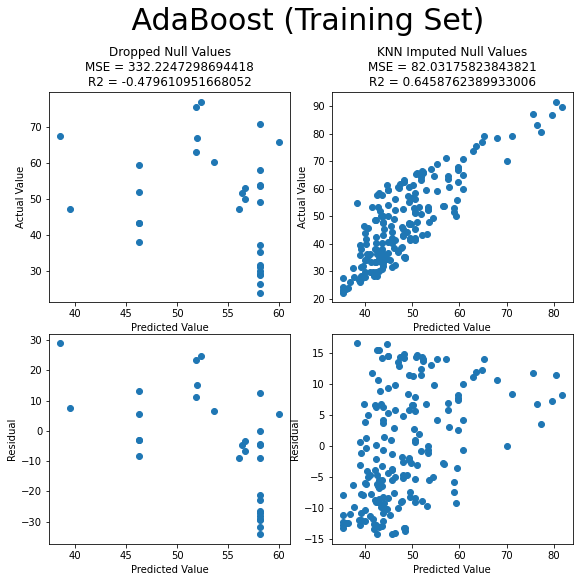

In [18]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Plot the predicted versus actual values and the residual versus predicted values
predict_ABR_dropnulls = ABR_dropnulls.predict(X_train_scaled_dropnulls)
residual_ABR_dropnulls = y_train_dropnulls - predict_ABR_dropnulls
MSE_ABR_dropnulls = mean_squared_error(
    y_train_dropnulls, predict_ABR_dropnulls)

predict_ABR_KNNImpute = ABR_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_ABR_KNNImpute = y_train_KNNImpute - predict_ABR_KNNImpute
MSE_ABR_KNNImpute = mean_squared_error(y_train_KNNImpute, predict_ABR_KNNImpute)

cols = [f'Dropped Null Values\nMSE = {MSE_ABR_dropnulls}\nR2 = {ABR_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'KNN Imputed Null Values\nMSE = {MSE_ABR_KNNImpute}\nR2 = {ABR_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' AdaBoost (Training Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()

axis[0, 0].scatter(predict_ABR_dropnulls, y_train_dropnulls)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR_dropnulls, residual_ABR_dropnulls)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_ABR_KNNImpute, y_train_KNNImpute)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_ABR_KNNImpute, residual_ABR_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")


plt.show()



## Support Vector Regression
This method works well to fit non-linear relationships. Tuning can be done on the type of surfaces used to fit as well as other hyper-parameters. It is recommended that SVR data be scaled.

In [19]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


SVR_REG = SVR(cache_size = 1000)
params = {
    'kernel': ["rbf", "linear", "poly", "sigmoid"],
    'C': [.5, .7, 1.0, 1.1, 1.2, 1.3, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5 , 6] }

regr_dropnulls = GridSearchCV(
    estimator=SVR_REG,
    param_grid=params,
    cv=7,
    n_jobs=3,
    verbose=2
)
regr_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
print(f"Dropped Nulls: tuned parameters = {regr_dropnulls.best_params_}")

regr_KNNImpute = GridSearchCV(
    estimator=SVR_REG,
    param_grid=params,
    cv=7,
    n_jobs=3,
    verbose=2
)
regr_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
print(f"KNN Imputed: tuned parameters = {regr_KNNImpute.best_params_}")

svr_opt_dropnulls = SVR(C=regr_dropnulls.best_params_['C'], 
                        kernel=regr_dropnulls.best_params_['kernel'], 
                        degree=regr_dropnulls.best_params_['degree'],
                        gamma=regr_dropnulls.best_params_['gamma'])
svr_opt_dropnulls.fit(X_train_scaled_dropnulls, y_train_dropnulls)
scores = cross_val_score(svr_opt_dropnulls, X_train_scaled_dropnulls, y_train_dropnulls, cv=5)
print("Tuned SVR Results -- Dropped Nulls")
print(scores.mean())
print(
    f"TRAIN: R2={svr_opt_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)} MSE={mean_squared_error(y_train_dropnulls, svr_opt_dropnulls.predict(X_train_scaled_dropnulls))}")
print(f"TEST: R2={svr_opt_dropnulls.score(X_test_scaled_dropnulls, y_test_dropnulls)} MSE={mean_squared_error(y_test_dropnulls, svr_opt_dropnulls.predict(X_test_scaled_dropnulls))}")

svr_opt_KNNImpute = SVR(C=regr_KNNImpute.best_params_['C'],
                        kernel=regr_KNNImpute.best_params_['kernel'],
                        degree=regr_KNNImpute.best_params_['degree'],
                        gamma=regr_KNNImpute.best_params_['gamma'])
svr_opt_KNNImpute.fit(X_train_scaled_KNNImpute, y_train_KNNImpute)
scores = cross_val_score(
    svr_opt_KNNImpute, X_train_scaled_KNNImpute, y_train_KNNImpute, cv=5)
print("Tuned SVR Results -- KNN Imputed")
print(scores.mean())
print(
    f"TRAIN: R2={svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)} MSE={mean_squared_error(y_train_KNNImpute, svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute))}")
print(f"TEST: R2={svr_opt_KNNImpute.score(X_test_scaled_KNNImpute, y_test_KNNImpute)} MSE={mean_squared_error(y_test_KNNImpute, svr_opt_KNNImpute.predict(X_test_scaled_KNNImpute))}")


Fitting 7 folds for each of 2300 candidates, totalling 16100 fits
Dropped Nulls: tuned parameters = {'C': 9.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 7 folds for each of 2300 candidates, totalling 16100 fits
KNN Imputed: tuned parameters = {'C': 3.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Tuned SVR Results -- Dropped Nulls
0.3249345563163467
TRAIN: R2=0.6904015322837945 MSE=69.51575154877948
TEST: R2=0.21208442513712877 MSE=140.06052375752057
Tuned SVR Results -- KNN Imputed
-0.011209613671919704
TRAIN: R2=0.2240805780251519 MSE=179.7395189043678
TEST: R2=-0.036980917510538225 MSE=187.15983270920182


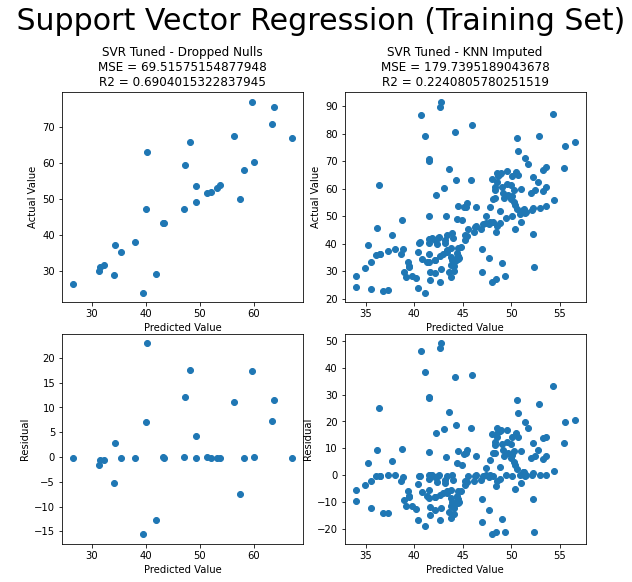

In [23]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_svr_opt_dropnulls = svr_opt_dropnulls.predict(X_train_scaled_dropnulls)
residual_svr_opt_dropnulls = y_train_dropnulls - predict_svr_opt_dropnulls
MSE_svr_opt_dropnulls = mean_squared_error(y_train_dropnulls, predict_svr_opt_dropnulls)

predict_svr_opt_KNNImpute = svr_opt_KNNImpute.predict(X_train_scaled_KNNImpute)
residual_svr_opt_KNNImpute = y_train_KNNImpute - predict_svr_opt_KNNImpute
MSE_svr_opt_KNNImpute = mean_squared_error(y_train_KNNImpute, predict_svr_opt_KNNImpute)


cols = [f'SVR Tuned - Dropped Nulls\nMSE = {MSE_svr_opt_dropnulls}\nR2 = {svr_opt_dropnulls.score(X_train_scaled_dropnulls, y_train_dropnulls)}',
        f'SVR Tuned - KNN Imputed\nMSE = {MSE_svr_opt_KNNImpute}\nR2 = {svr_opt_KNNImpute.score(X_train_scaled_KNNImpute, y_train_KNNImpute)}']
#rows = ['','']

figure, axis = plt.subplots(2, 2, figsize=(8, 8))
figure.suptitle(' Support Vector Regression (Training Set)', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

#for ax, row in zip(axis[:, 0], rows):
#    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()

axis[0, 0].scatter(predict_svr_opt_dropnulls, y_train_dropnulls)
axis[0,0].set_xlabel("Predicted Value")
axis[0,0].set_ylabel("Actual Value")

axis[1,0].scatter(predict_svr_opt_dropnulls, residual_svr_opt_dropnulls)
axis[1,0].set_ylabel("Residual")
axis[1,0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_opt_KNNImpute, y_train_KNNImpute)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_opt_KNNImpute, residual_svr_opt_KNNImpute)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

plt.show()



## Voting Regressor
Take the pretty poor regressors that we developed above and use them together in an ensemble to improve their functionality.

In [55]:
from sklearn.ensemble import VotingRegressor

ereg = VotingRegressor(
    estimators=[('ABR', ABR), ('svr_opt', svr_opt)])
ereg = ereg.fit(X_train_scaled, y_train)
scores = cross_val_score(ereg, X_train_scaled, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {ereg.score(X_train_scaled, y_train)}")
print(f"TEST: {ereg.score(X_test, y_test)}")


0.32078490977753416
TRAIN: 0.8023587937977841
TEST: -12.67355577521652


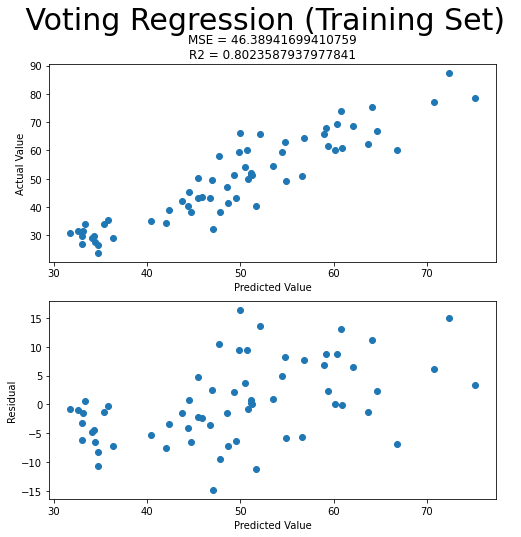

In [56]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_ereg = ereg.predict(X_train_scaled)
residual_ereg = y_train - predict_ereg
MSE_ereg = mean_squared_error(y_train, predict_ereg)

figure, axis = plt.subplots(2, 1, figsize=(8, 8))
figure.suptitle(' Voting Regression (Training Set) ', fontsize=30)
axis[0].scatter(predict_ereg, y_train)
axis[0].set_xlabel("Predicted Value")
axis[0].set_ylabel("Actual Value")
axis[0].set_title(
    f"MSE = {MSE_ereg}\nR2 = {ereg.score(X_train_scaled, y_train)}")

axis[1].scatter(predict_ereg, residual_ereg)
axis[1].set_ylabel("Residual")
axis[1].set_xlabel("Predicted Value")


plt.show()


## Plot all of them together for training and test sets

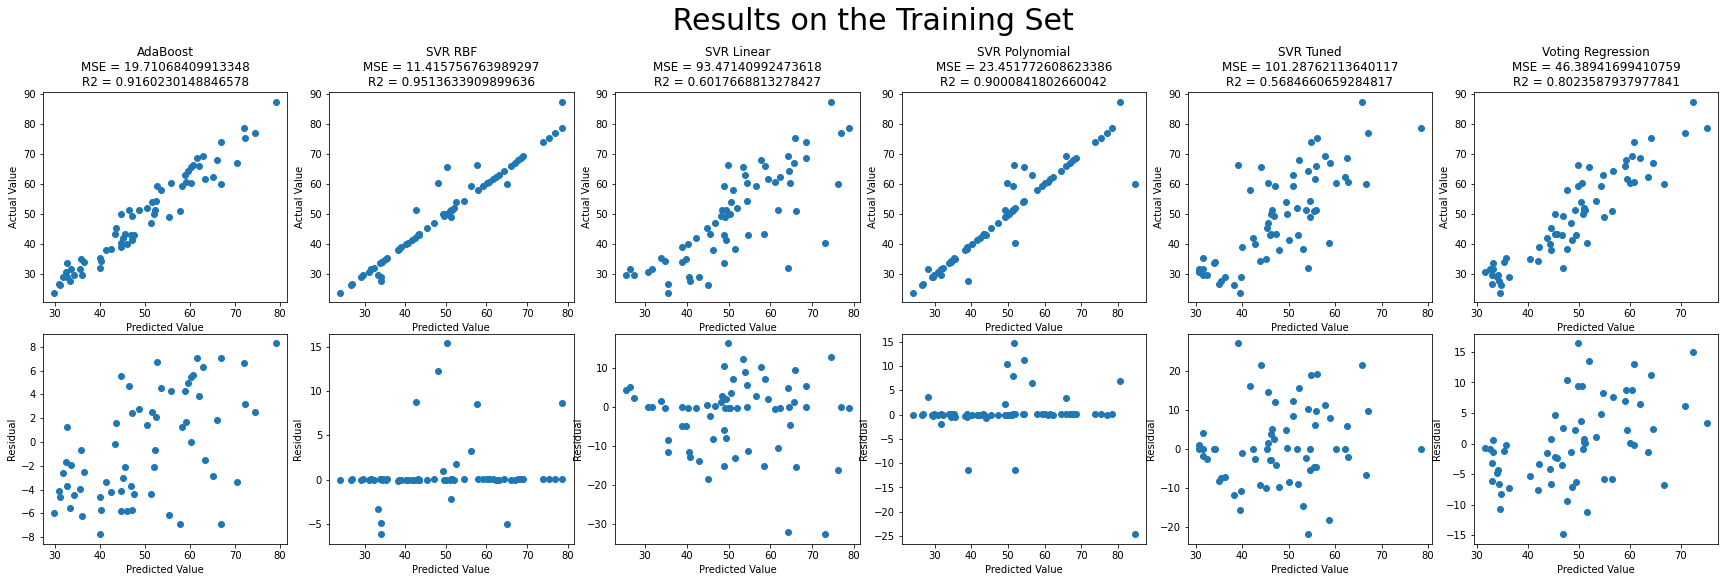

In [58]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR = ABR.predict(X_train_scaled)
residual_ABR = y_train - predict_ABR

predict_svr_rbf = svr_rbf.predict(X_train_scaled)
residual_svr_rbf = y_train - predict_svr_rbf

predict_svr_linear = svr_linear.predict(X_train_scaled)
residual_svr_linear = y_train - predict_svr_linear

predict_svr_poly = svr_poly.predict(X_train_scaled)
residual_svr_poly = y_train - predict_svr_poly

predict_svr_opt = svr_opt.predict(X_train_scaled)
residual_svr_opt = y_train - predict_svr_opt

predict_ereg = ereg.predict(X_train_scaled)
residual_ereg = y_train - predict_ereg

cols = [f'AdaBoost\nMSE = {MSE_ABR}\nR2 = {ABR.score(X_train_scaled, y_train)}',
        f'SVR RBF\nMSE = {MSE_svr_rbf}\nR2 = {svr_rbf.score(X_train_scaled, y_train)}', 
        f'SVR Linear\nMSE = {MSE_svr_linear}\nR2 = {svr_linear.score(X_train_scaled, y_train)}', 
        f'SVR Polynomial\nMSE = {MSE_svr_poly}\nR2 = {svr_poly.score(X_train_scaled, y_train)}',
        f'SVR Tuned\nMSE = {MSE_svr_opt}\nR2 = {svr_opt.score(X_train_scaled, y_train)}',
        f'Voting Regression\nMSE = {MSE_ereg}\nR2 = {ereg.score(X_train_scaled, y_train)}']


figure, axis = plt.subplots(2, 6, figsize=(24, 8))
figure.suptitle(' Results on the Training Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)


figure.tight_layout()


axis[0, 0].scatter(predict_ABR, y_train)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR, residual_ABR)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_rbf, y_train)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_rbf, residual_svr_rbf)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_svr_linear, y_train)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_svr_linear, residual_svr_linear)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_svr_poly, y_train)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_svr_poly, residual_svr_poly)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_svr_opt, y_train)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_svr_opt, residual_svr_opt)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")

axis[0, 5].scatter(predict_ereg, y_train)
axis[0, 5].set_xlabel("Predicted Value")
axis[0, 5].set_ylabel("Actual Value")

axis[1, 5].scatter(predict_ereg, residual_ereg)
axis[1, 5].set_ylabel("Residual")
axis[1, 5].set_xlabel("Predicted Value")


plt.show()


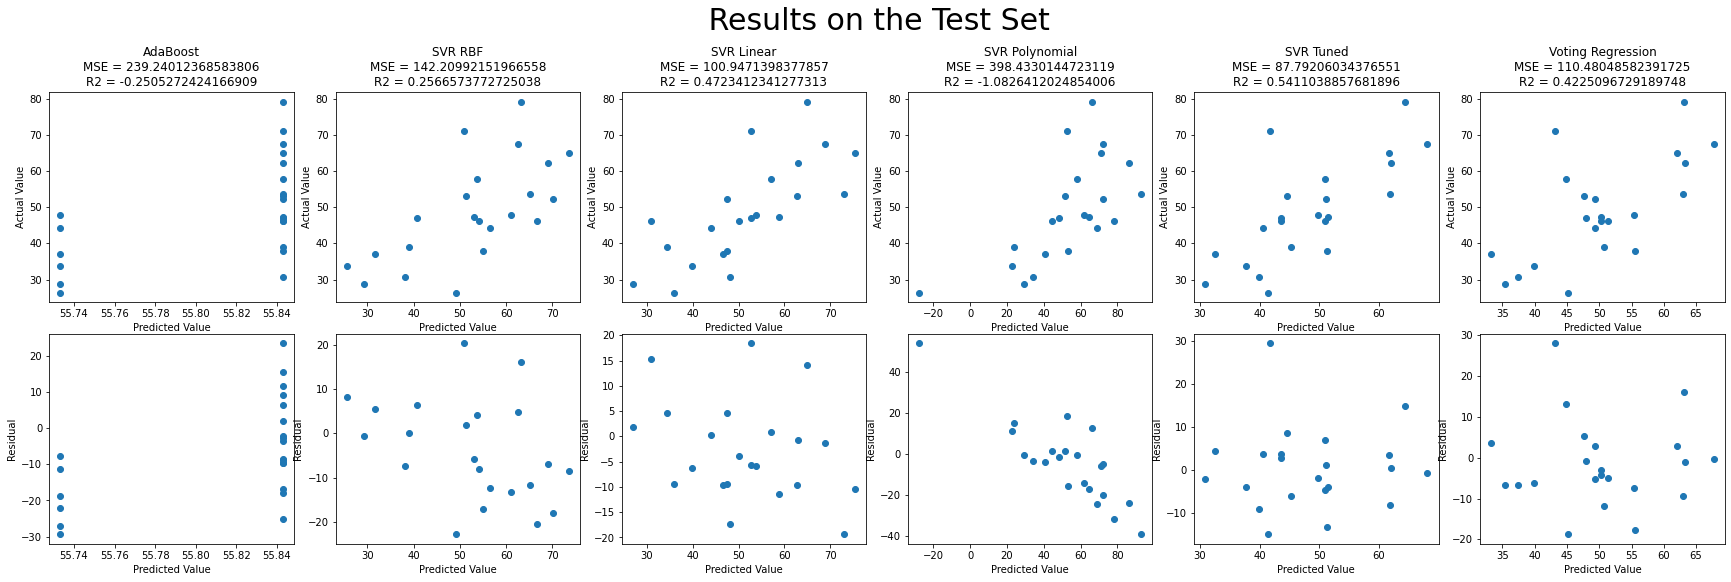

In [59]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR = ABR.predict(X_test)
residual_ABR = y_test - predict_ABR
MSE_ABR = mean_squared_error(y_test, predict_ABR)

predict_svr_rbf = svr_rbf.predict(X_test_scaled)
residual_svr_rbf = y_test - predict_svr_rbf
MSE_svr_rbf = mean_squared_error(y_test, predict_svr_rbf)

predict_svr_linear = svr_linear.predict(X_test_scaled)
residual_svr_linear = y_test - predict_svr_linear
MSE_svr_linear = mean_squared_error(y_test, predict_svr_linear)

predict_svr_poly = svr_poly.predict(X_test_scaled)
residual_svr_poly = y_test - predict_svr_poly
MSE_svr_poly = mean_squared_error(y_test, predict_svr_poly)

predict_svr_opt = svr_opt.predict(X_test_scaled)
residual_svr_opt = y_test - predict_svr_opt
MSE_svr_opt = mean_squared_error(y_test, predict_svr_opt)

predict_ereg = ereg.predict(X_test_scaled)
residual_ereg = y_test - predict_ereg
MSE_ereg = mean_squared_error(y_test, predict_ereg)

cols = [f'AdaBoost\nMSE = {MSE_ABR}\nR2 = {ABR.score(X_test, y_test)}',
        f'SVR RBF\nMSE = {MSE_svr_rbf}\nR2 = {svr_rbf.score(X_test_scaled, y_test)}',
        f'SVR Linear\nMSE = {MSE_svr_linear}\nR2 = {svr_linear.score(X_test_scaled, y_test)}',
        f'SVR Polynomial\nMSE = {MSE_svr_poly}\nR2 = {svr_poly.score(X_test_scaled, y_test)}',
        f'SVR Tuned\nMSE = {MSE_svr_opt}\nR2 = {svr_opt.score(X_test_scaled, y_test)}',
        f'Voting Regression\nMSE = {MSE_ereg}\nR2 = {ereg.score(X_test_scaled, y_test)}']


figure, axis = plt.subplots(2, 6, figsize=(24, 8))
figure.suptitle(' Results on the Test Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

figure.tight_layout()


axis[0, 0].scatter(predict_ABR, y_test)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR, residual_ABR)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_rbf, y_test)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_rbf, residual_svr_rbf)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_svr_linear, y_test)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_svr_linear, residual_svr_linear)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_svr_poly, y_test)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_svr_poly, residual_svr_poly)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_svr_opt, y_test)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_svr_opt, residual_svr_opt)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")

axis[0, 5].scatter(predict_ereg, y_test)
axis[0, 5].set_xlabel("Predicted Value")
axis[0, 5].set_ylabel("Actual Value")

axis[1, 5].scatter(predict_ereg, residual_ereg)
axis[1, 5].set_ylabel("Residual")
axis[1, 5].set_xlabel("Predicted Value")


plt.show()
